# Importation des librairies nécessaires

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.ensemble import RandomForestClassifier

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 
from sklearn_pandas import DataFrameMapper

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, roc_curve, auc

# SMOTE
from imblearn.over_sampling import SMOTE

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# YELLOWBRICK
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

# Importation des modules

In [29]:
# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importations des modules nécessaires
import data_loader
import preprocessing
import modeling
import evaluation
import cleaning

# Chargement des données

In [30]:
data_path = '../data/smoking_driking_dataset_Ver01.csv'
target_column = 'SMK_stat_type_cd' 
output_path = '../data/balanced_smoking_drinking_dataset.csv'

# Équilibrer le dataset
df_balanced = data_loader.balance_dataset(data_path, target_column, output_path)

Distribution des classes dans le dataset équilibré :
SMK_stat_type_cd
1.0    174951
2.0    174951
3.0    174951
Name: count, dtype: int64


# Nettoyage des données

## Type des variables

In [31]:
intToFloat = ['age', 'height', 'weight']
floatToInt = ['hear_left', 'hear_right', 'urine_protein', 'SMK_stat_type_cd']

In [32]:
cleaning.convertType(df_balanced, intToFloat, floatToInt)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Female,70.0,155.0,40.0,61.0,0.9,0.9,1,1,124.0,...,141.0,63.0,13.2,2,0.8,30.0,9.0,24.0,1,N
1,Male,75.0,160.0,65.0,82.0,0.5,0.5,2,2,177.0,...,88.0,116.0,13.3,4,0.9,18.0,28.0,29.0,1,N
2,Female,45.0,150.0,55.0,81.0,1.0,1.0,1,1,175.0,...,201.0,104.0,13.8,1,1.0,29.0,25.0,18.0,1,N
3,Female,70.0,155.0,65.0,85.0,0.8,0.7,1,1,166.0,...,147.0,169.0,11.4,1,0.9,28.0,24.0,20.0,1,Y
4,Female,45.0,155.0,55.0,75.5,0.7,0.9,1,1,95.0,...,123.0,176.0,12.7,1,0.8,23.0,23.0,29.0,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524848,Male,35.0,170.0,65.0,80.2,0.7,0.6,1,1,120.0,...,55.0,51.0,14.1,1,0.5,24.0,31.0,47.0,3,Y
524849,Male,40.0,175.0,60.0,74.0,1.2,0.8,1,1,122.0,...,109.0,125.0,14.8,1,1.2,22.0,17.0,69.0,3,Y
524850,Male,30.0,165.0,75.0,84.0,0.9,1.2,1,1,126.0,...,139.0,240.0,16.5,1,0.5,37.0,57.0,123.0,3,Y
524851,Male,30.0,165.0,70.0,83.5,1.2,1.0,1,1,160.0,...,71.0,51.0,15.6,1,0.8,23.0,25.0,75.0,3,Y


In [38]:
df_balanced.dtypes

sex                  object
age                 float64
height              float64
weight              float64
waistline           float64
sight_left          float64
sight_right         float64
hear_left             int64
hear_right            int64
SBP                 float64
DBP                 float64
BLDS                float64
tot_chole           float64
HDL_chole           float64
LDL_chole           float64
triglyceride        float64
hemoglobin          float64
urine_protein         int64
serum_creatinine    float64
SGOT_AST            float64
SGOT_ALT            float64
gamma_GTP           float64
SMK_stat_type_cd      int64
DRK_YN               object
dtype: object

In [39]:
cont_features = df_balanced.select_dtypes(include=['float64']).columns
cat_features = df_balanced.select_dtypes(include=['object', 'int64']).columns
cat_features = cat_features.drop(['SMK_stat_type_cd', 'DRK_YN'])

In [40]:
cont_features, cat_features

(Index(['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
        'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole',
        'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST',
        'SGOT_ALT', 'gamma_GTP'],
       dtype='object'),
 Index(['sex', 'hear_left', 'hear_right', 'urine_protein'], dtype='object'))

# Séparation données train / test

In [41]:
X = df_balanced.drop(columns=['SMK_stat_type_cd', 'DRK_YN'])
y = df_balanced['SMK_stat_type_cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
y_train.value_counts(), y_test.value_counts()

(SMK_stat_type_cd
 1    139961
 2    139961
 3    139960
 Name: count, dtype: int64,
 SMK_stat_type_cd
 3    34991
 1    34990
 2    34990
 Name: count, dtype: int64)

## Sélection de variables

### Validation croisée pour avoir la meilleure valeur de k features à retenir

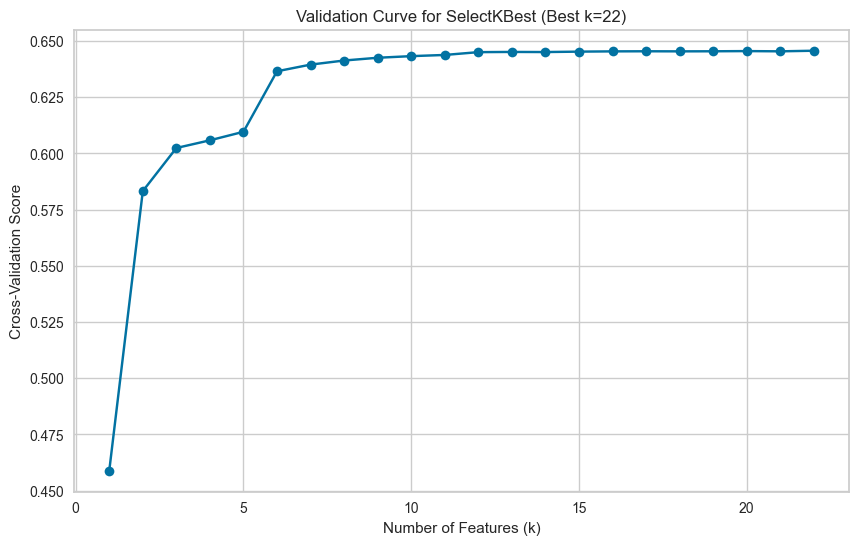

Best k: 22
Best cross-validation score: 0.645635760602923


In [43]:
def preprocess_data_without_selecting(X_train, X_test, cont_features, cat_features):
    """"
    Renvoie les données prétraitées pour l'entraînement et le test, ainsi que le preprocessor utilisé.
    """
    
    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    return X_train_prep, X_test_prep, preprocessor

def plot_and_select_best_k(X_train, y_train, preprocessor, k_values):
    """
    Trace la courbe de validation pour SelectKBest et renvoie le meilleur k et le meilleur score.
    Modèle utilisé : LogisticRegression simple
    """

    scores = []
    best_k = None
    best_score = -np.inf

    for k in k_values:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        
        model = LogisticRegression()
        cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
        mean_cv_score = np.mean(cv_scores)
        scores.append(mean_cv_score)
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_k = k
        
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, scores, marker='o')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('Cross-Validation Score')
    plt.title(f'Validation Curve for SelectKBest (Best k={best_k})')
    plt.grid(True)
    plt.show()
    
    return best_k, best_score

# Prétraiter les données
X_train_prep, X_test_prep, preprocessor = preprocess_data_without_selecting(X_train, X_test, cont_features, cat_features)

# Définir les valeurs de k à tester
k_values = range(1, X_train_prep.shape[1] + 1)

# Trouver le meilleur k
best_k, best_score = plot_and_select_best_k(X_train_prep, y_train, preprocessor, k_values)

print(f"Best k: {best_k}")
print(f"Best cross-validation score: {best_score}")

<font color='red'>**Commentaire**</font> 

On aperçoit une certaine stabilisation à partir de k=12. Nous choisissons donc ce k afin de réduire la dimension (le score optimal est obtenu pour k=22, càd toutes les features)

### Sélection

In [48]:
def preprocess_data(X_train, X_test, cont_features, cat_features, target, k):
    """
    Preprocess the data and select the top k features using SelectKBest.
    """

    # Preprocess numerical features
    cont_preprocessor = make_pipeline(StandardScaler())
    
    # Preprocess categorical features
    cat_preprocessor = make_pipeline(OrdinalEncoder())
    
    preprocessor = make_column_transformer((cont_preprocessor, cont_features),
                                           (cat_preprocessor, cat_features),
                                           remainder='drop')
    
    # Fit and transform the training data
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    
    # SelectKBest to select the top k features
    selector = SelectKBest(score_func=f_classif, k=k)    
    X_train_selected = selector.fit_transform(X_train_prep, target)
    X_test_selected = selector.transform(X_test_prep)
    
    # Get the selected feature names
    selected_features = selector.get_support(indices=True)
    feature_names = preprocessor.get_feature_names_out()
    selected_feature_names = [feature_names[i] for i in selected_features]

    print("Selected feature names:", selected_feature_names)
    
    return X_train_selected, X_test_selected, selected_feature_names

In [49]:
# Nombre de caractéristiques à sélectionner
k = 12

X_train_prep, X_test_prep, feature_names = preprocess_data(X_train, X_test, cont_features, cat_features, y_train, k)

Selected feature names: ['pipeline-1__age', 'pipeline-1__height', 'pipeline-1__weight', 'pipeline-1__waistline', 'pipeline-1__DBP', 'pipeline-1__HDL_chole', 'pipeline-1__triglyceride', 'pipeline-1__hemoglobin', 'pipeline-1__serum_creatinine', 'pipeline-1__SGOT_ALT', 'pipeline-1__gamma_GTP', 'pipeline-2__sex']


# Modélisation

In [50]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap='Blues', figsize=(10, 7)):
    """
    Plots a confusion matrix using matplotlib.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.
    classes : array-like of shape (n_classes,)
        List of class labels.
    cmap : str, default='Blues'
        Colormap for the heatmap.
    figsize : tuple, default=(10, 7)
        Figure size.
    """
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Créer une figure et un axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Créer une heatmap
    cax = ax.matshow(cm, cmap=cmap)
    
    # Ajouter une barre de couleur
    fig.colorbar(cax)
    
    # Annoter la heatmap avec les valeurs de la matrice de confusion
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black')
    
    # Définir les labels des axes
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
    
    # Définir les labels des axes et le titre
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    # Afficher la heatmap
    plt.show()

In [51]:
def evaluate_model_multiclass(y_true, y_pred, class_labels):
    """
    Evaluate a multi-class classification model using confusion matrix, classification metrics, 
    and ROC AUC.

    Args:
        y_true (array): True class labels.
        y_pred (array): Predicted class labels.
        class_labels (array): List of class labels.
    """
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=class_labels)

    # Calculate classification metrics
    # precision = precision_score(y_true, y_pred, average='weighted')
    # recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Display classification metrics
    print("*** Classification Metrics ***")
    # print("Precision =", precision)
    # print("Recall =", recall)
    print("F1 Score =", f1)
    print("******************************")

    # Binarize the output
    y_onehot_test = label_binarize(y_true, classes=class_labels)
    y_score = label_binarize(y_pred, classes=class_labels)

    # ROC AUC for multi-class classification
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC=%0.3f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Multi-class ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC scores for each class
    print("AUC scores for each class:", roc_auc)

    # Calculate micro-average ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (AUC = %0.3f)' % roc_auc["micro"], color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Micro-averaged ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Régression logistique 

In [52]:
# Modèles
logreg = LogisticRegression(penalty=None, tol=10e-6, random_state=42, solver='lbfgs')
logregRidge = LogisticRegression(C=0.1, penalty='l2', tol=10e-6, random_state=42, solver='lbfgs')
logregLasso = LogisticRegression(C=0.1, penalty='l1', tol=10e-6, random_state=42, max_iter=1000, solver='saga')
logregElasticNet = LogisticRegression(C=0.1, penalty='elasticnet', l1_ratio=0.7, tol=10e-6, random_state=42, max_iter=1000, solver='saga')

In [53]:
# Créer et entraîner un modèle de régression logistique

logreg.fit(X_train_prep, y_train)

LogisticRegression(penalty=None, random_state=42, tol=1e-05)

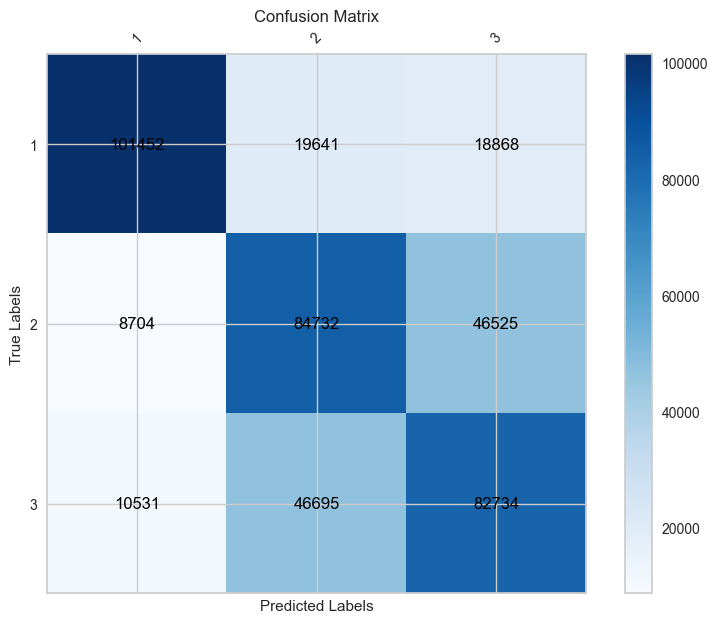

*** Classification Metrics ***
F1 Score = 0.645040329810779
******************************


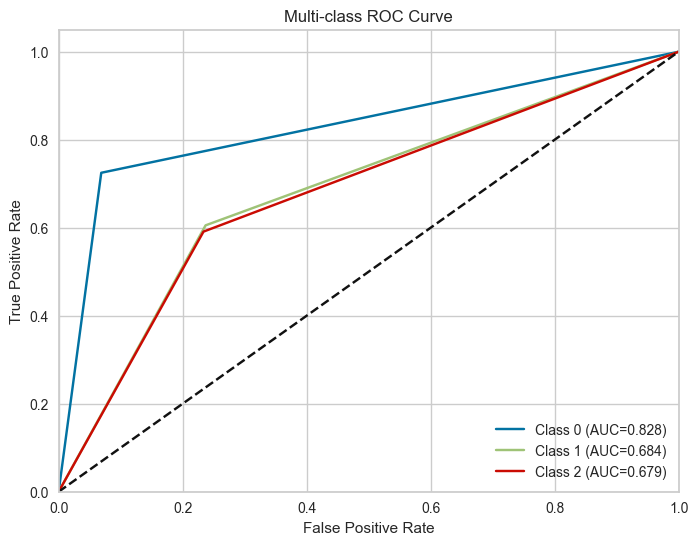

AUC scores for each class: {0: 0.8280716258175201, 1: 0.6842080347719217, 2: 0.6787572649739427}


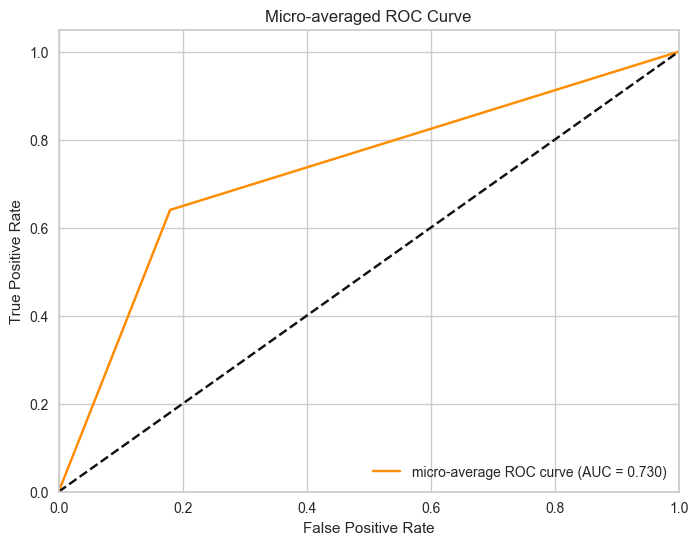

In [55]:
# Evaluer le modèle sur les données train
y_train_pred = logreg.predict(X_train_prep)
evaluate_model_multiclass(y_train, y_train_pred, logreg.classes_)

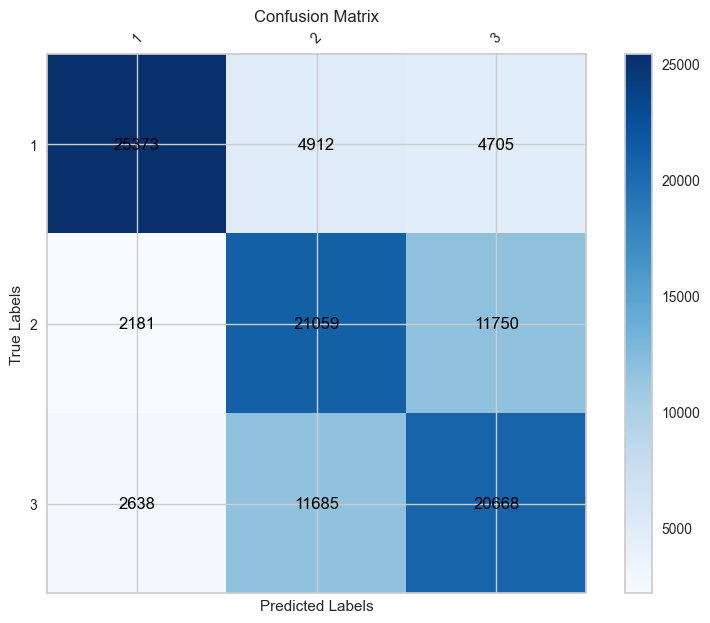

*** Classification Metrics ***
F1 Score = 0.6438332427049808
******************************


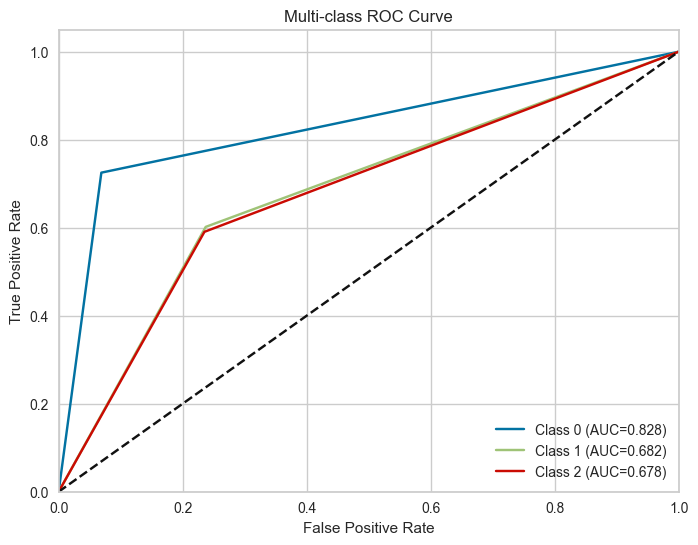

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6823466502170134, 2: 0.6777637801347342}


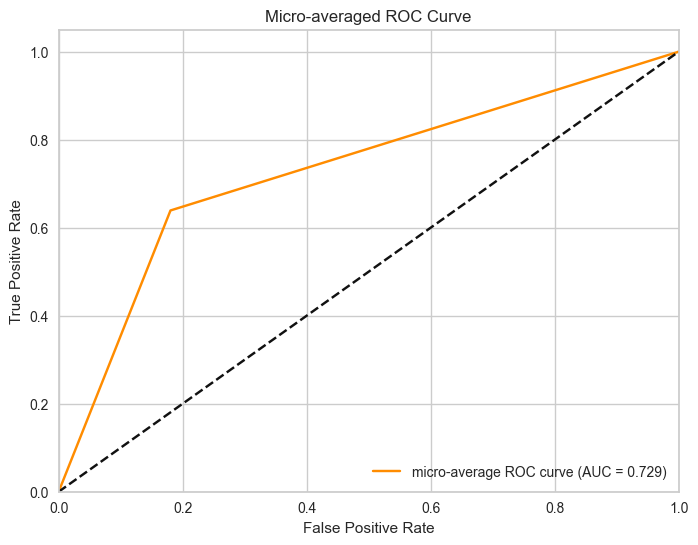

In [21]:
# Evaluer le modèle sur les données test
y_test_pred = logreg.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logreg.classes_)

<font color='red'>**Commentaire**</font> 

Ajoutons une pénalisation pour tenter d'améliorer le modèle.

## Régression logistique + pénalité

In [56]:
dict_models_pen = {
    # 'Logistic Regression (Ridge)': logregRidge, 
    'Logistic Regression (Lasso)': logregLasso,
    'Logistic Regression (Elastic Net)': logregElasticNet
}



*** Logistic Regression (Ridge) ***


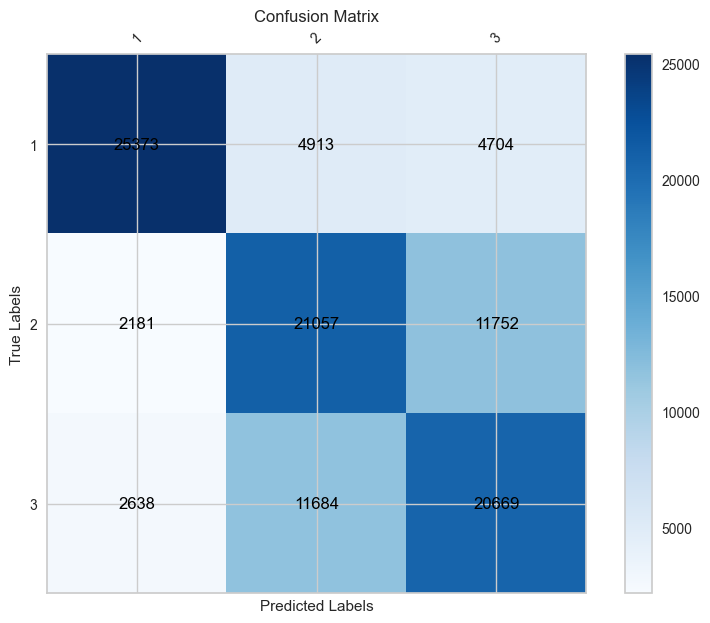

*** Classification Metrics ***
F1 Score = 0.64382415467185
******************************


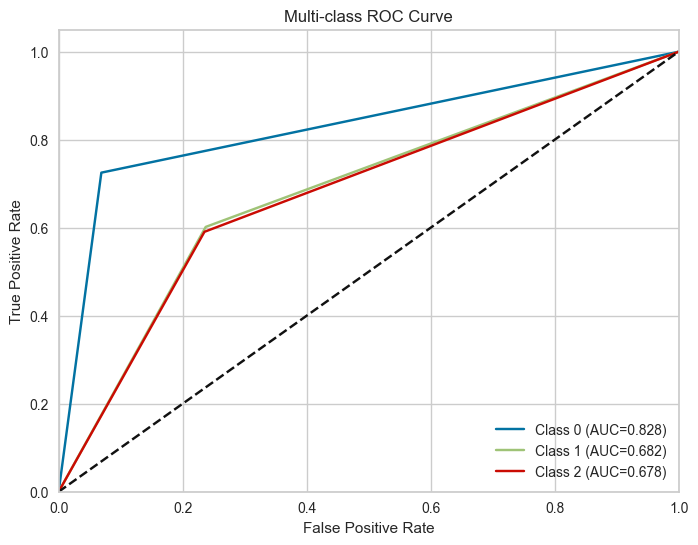

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6823180706228436, 2: 0.6777709246248917}


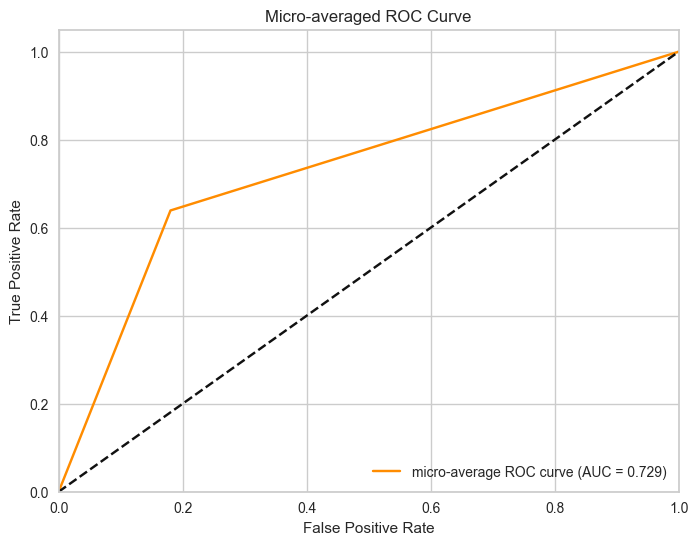



*** Logistic Regression (Lasso) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


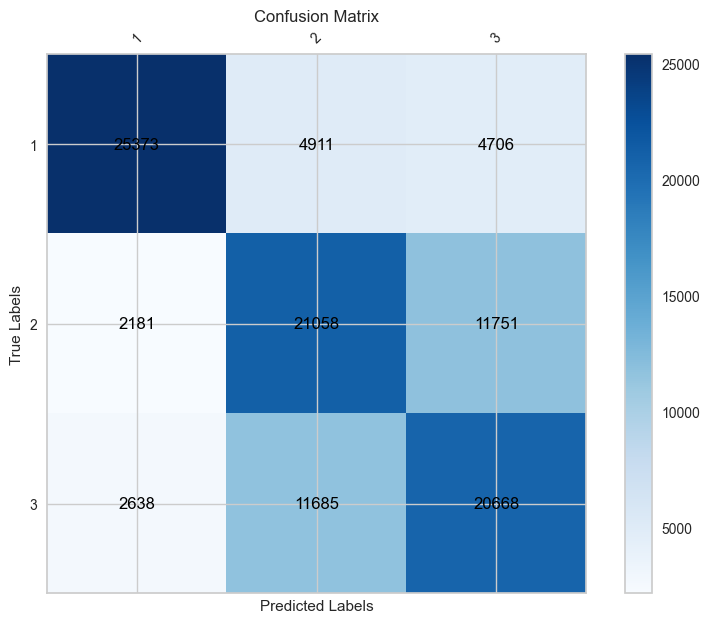

*** Classification Metrics ***
F1 Score = 0.6438240872172648
******************************


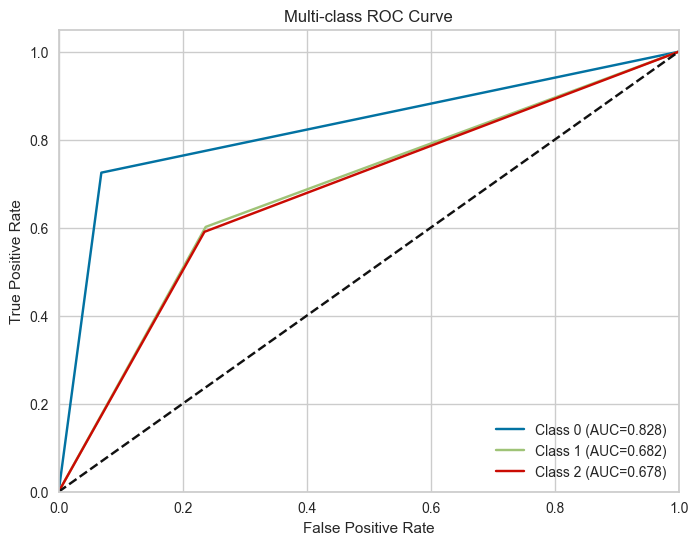

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6823395052163733, 2: 0.6777494903376493}


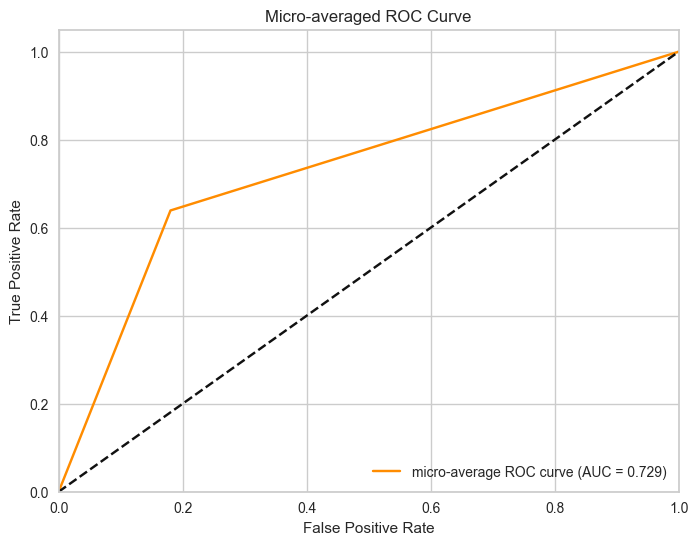



*** Logistic Regression (Elastic Net) ***


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


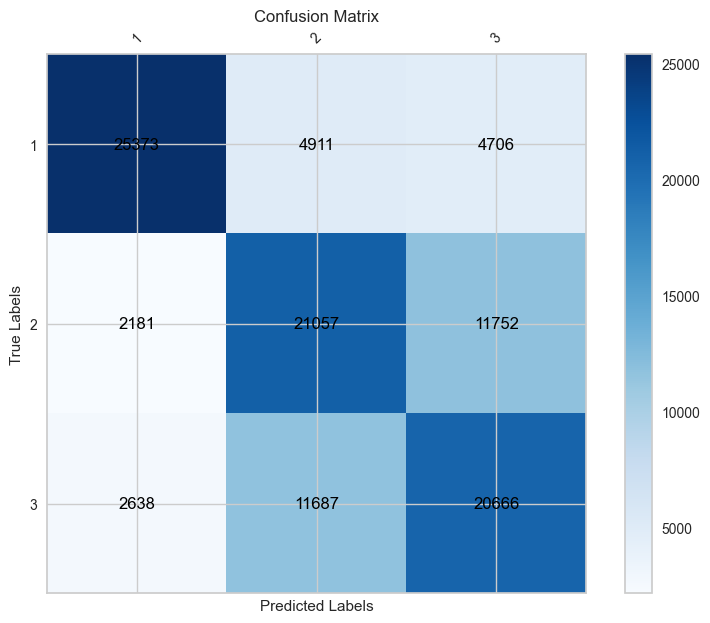

*** Classification Metrics ***
F1 Score = 0.6437964101699942
******************************


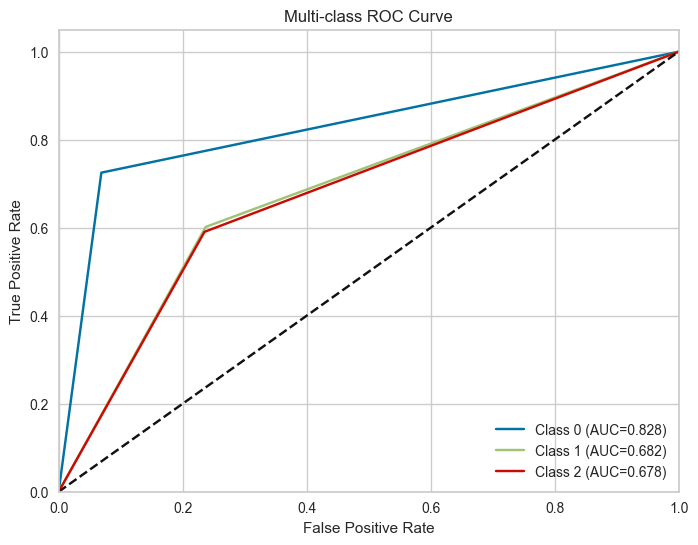

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6823109258263989, 2: 0.677713766661707}


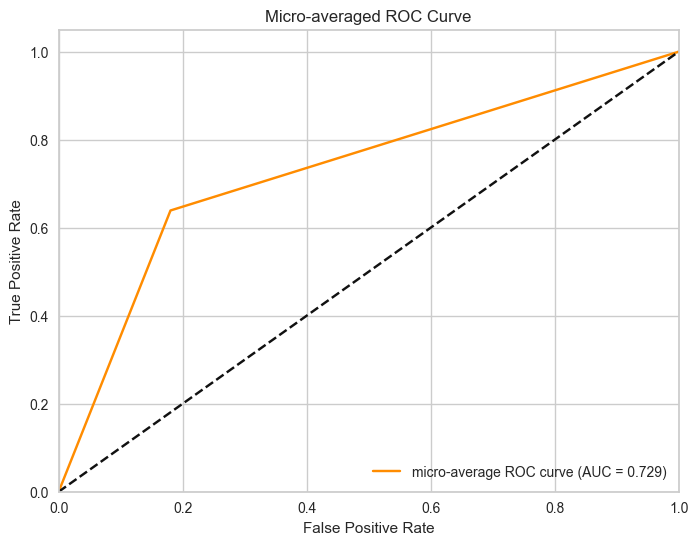

In [58]:
# Evaluate all models
for name, model in dict_models_pen.items():
    print('\n')
    print(f"*** {name} ***")
    model.fit(X_train_prep, y_train)
    y_test_pred = model.predict(X_test_prep)
    evaluate_model_multiclass(y_test, y_test_pred, model.classes_)

### Courbes de validation

In [62]:
def plot_validation_curve(model, X_train, y_train, param_name, param_range, cv=5, scoring='f1_weighted', title=None):
    """
    Plot validation curve for a logistic regression model.

    Args:
        model: The logistic regression model to evaluate.
        X_train: Training data.
        y_train: Training labels.
        param_name: Name of the parameter to vary.
        param_range: Range of parameter values to evaluate.
        cv: Number of cross-validation folds.
        scoring: Scoring method to use.
        title: Title of the plot.
    """
    train_scores, val_scores = validation_curve(
        model, 
        X_train, 
        y_train, 
        param_name=param_name, 
        param_range=param_range, 
        cv=cv, 
        scoring=scoring
    )

    plt.figure(figsize=(12, 4))
    plt.plot(param_range, train_scores.mean(axis=1), label='train')
    plt.plot(param_range, val_scores.mean(axis=1), label='validation')
    plt.legend()

    print("train scores:", train_scores.mean(axis=1))
    print("val scores:", val_scores.mean(axis=1))

    # Find the best C (maximum validation score)
    best_C_idx = np.argmax(val_scores.mean(axis=1))
    best_C = param_range[best_C_idx]

    if title is not None:
        plt.title(f'{title} (Best C: {best_C:.5f})')
    else:
        # plt.title(f'Validation Curve for {model.__class__.__name__}')
        plt.title(f'Validation Curve for Ridge Logistic Regression (Best C: {best_C:.5f})')
    plt.ylabel('Score')
    plt.xlabel(f'{param_name} (Regularization parameter)')
    plt.show()

    return best_C

train scores: [0.63933963 0.64488755 0.64498086 0.64502132 0.64501938 0.64502546
 0.64502591 0.64502683 0.64502497 0.64503112 0.64503453 0.64503222
 0.64503104 0.64502986 0.64502988 0.64502819 0.64502974 0.64502976
 0.6450331  0.64503252 0.64503485 0.64503264 0.6450332  0.64503549
 0.64503946 0.64504289 0.64504396 0.64504282 0.64504512 0.64504396]
val scores: [0.63939036 0.64486432 0.64497586 0.64498028 0.64503305 0.64503985
 0.64504906 0.6450416  0.64505077 0.64504148 0.64504617 0.64504609
 0.6450507  0.64504381 0.64504149 0.64502309 0.64502991 0.6450253
 0.64502759 0.64502528 0.64502065 0.64502068 0.64502297 0.64501797
 0.6450065  0.64501108 0.64501108 0.64501108 0.64501571 0.64500879]


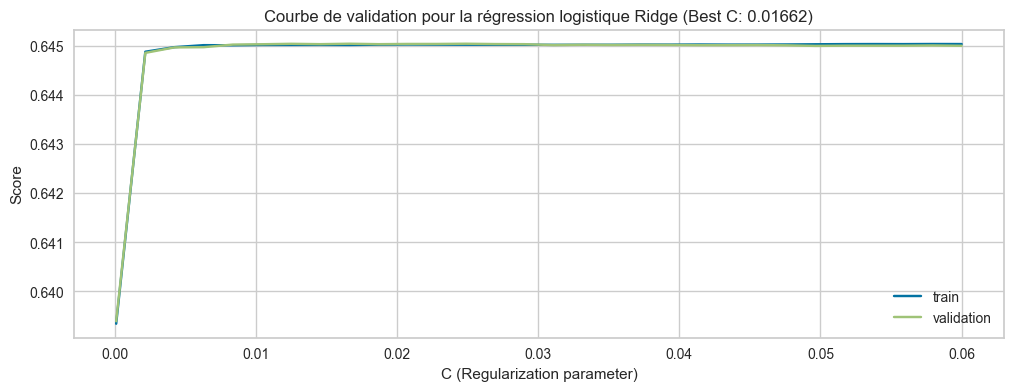

In [63]:
list_hyperparams = np.linspace(0.0001, 0.06, 30)

best_C = plot_validation_curve(
    logregRidge,
    X_train_prep, 
    y_train, 
    param_name='C', 
    param_range=list_hyperparams, 
    cv=5, 
    scoring='f1_weighted',
    title="Courbe de validation pour la régression logistique Ridge"
)

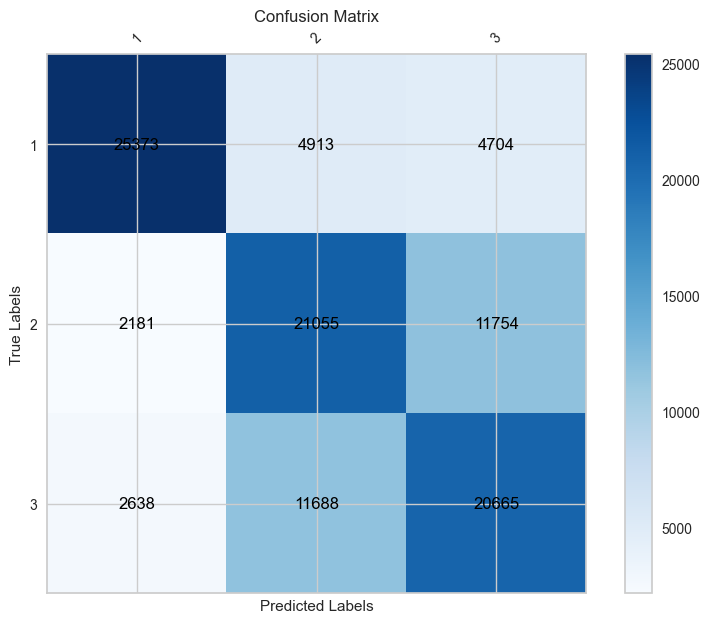

*** Classification Metrics ***
F1 Score = 0.6437688009729335
******************************


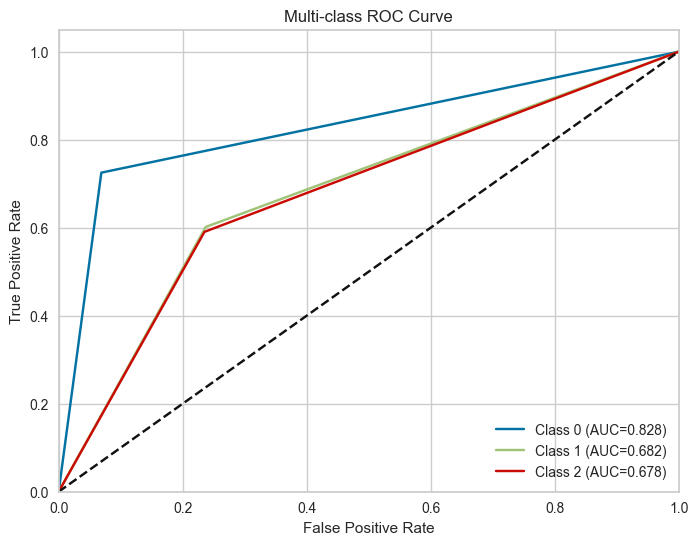

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6822609118428947, 2: 0.6776994772730072}


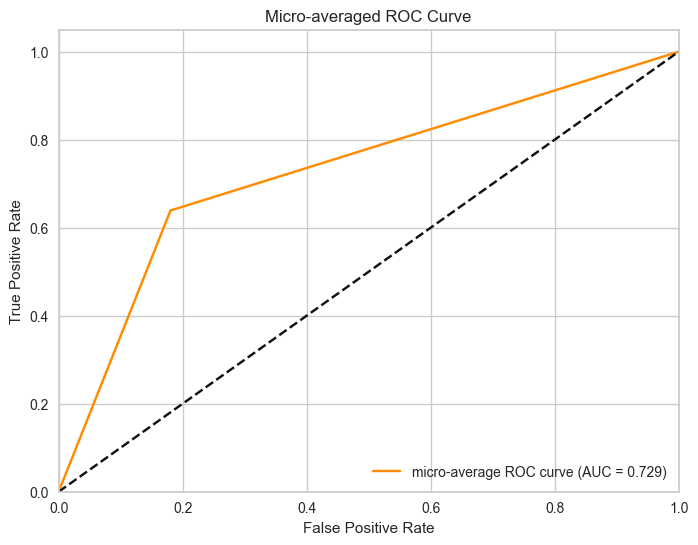

In [65]:
# Entrainer un modèle de régression logistique Ridge avec le meilleur hyperparamètre
logregRidge = LogisticRegression(C=best_C, penalty='l2', solver='lbfgs', tol=10e-6, random_state=42)
logregRidge.fit(X_train_prep, y_train)

# Prédire les données test et évaluer le modèle
y_test_pred = logregRidge.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logregRidge.classes_)

### Optimisation des hyper paramètres avec Optuna

In [47]:
# Définir une fonction objectif pour l'optimisation des hyperparamètres
def objective(trial):
    """
    Objective function for hyperparameter optimization.
    """
    # Définir l'espace de recherche pour les hyperparamètres
    C = trial.suggest_loguniform('C', 0.0001, 0.1)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None

    # Vérifier les combinaisons valides de solveurs et de pénalités
    if solver == 'lbfgs' and penalty not in ['l2', 'none']:
        raise optuna.exceptions.TrialPruned()
    if solver != 'saga' and penalty == 'elasticnet':
        raise optuna.exceptions.TrialPruned()
    
    # Initialiser le modèle
    hyperparameters = {
        'C': C,
        'penalty': penalty,
        'solver': solver,
        'tol': 1e-6,
        'max_iter': 1000,
        'random_state': 42
    }
    if l1_ratio is not None:
        hyperparameters['l1_ratio'] = l1_ratio

    model = LogisticRegression(**hyperparameters)

    # Entraîner le modèle
    model.fit(X_train_prep, y_train)

    # Prédire les résultats sur l'ensemble de test
    y_test_pred = model.predict(X_test_prep)

    # Calculer le score F1
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    return f1

In [67]:
import optuna

# Optimiser les hyperparamètres de la régression logistique Ridge

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2024-06-11 22:09:09,562] A new study created in memory with name: no-name-b775647b-cded-4406-be4b-b6756835ccfc
C:\Users\33667\AppData\Local\Temp\ipykernel_29468\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.0001, 0.1)
c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-06-11 22:15:55,059] Trial 0 finished with value: 0.6448187550323489 and parameters: {'C': 0.006948915389640227, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5458422666537074}. Best is trial 0 with value: 0.6448187550323489.
C:\Users\33667\AppData\Local\Temp\ipykernel_29468\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Number of finished trials:  100
Best trial: {'C': 0.010606096740994778, 'penalty': 'l2', 'solver': 'saga'}


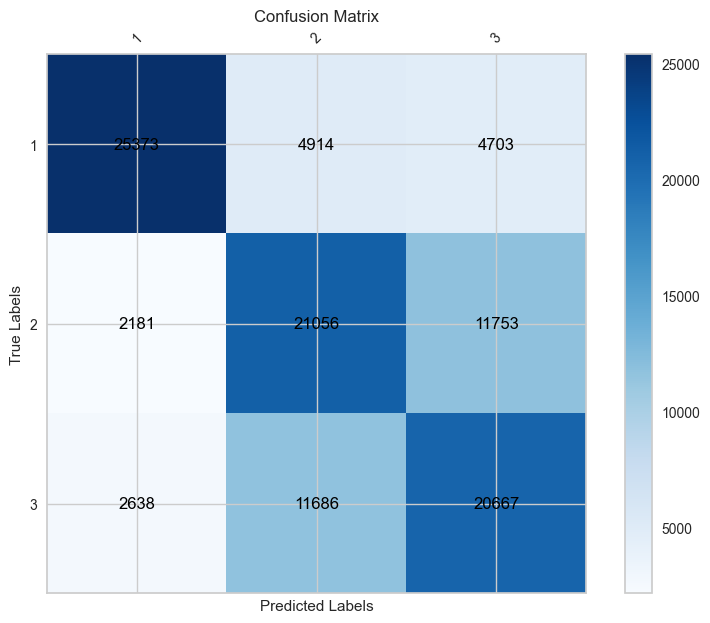

*** Classification Metrics ***
F1 Score = 0.6437964674035427
******************************


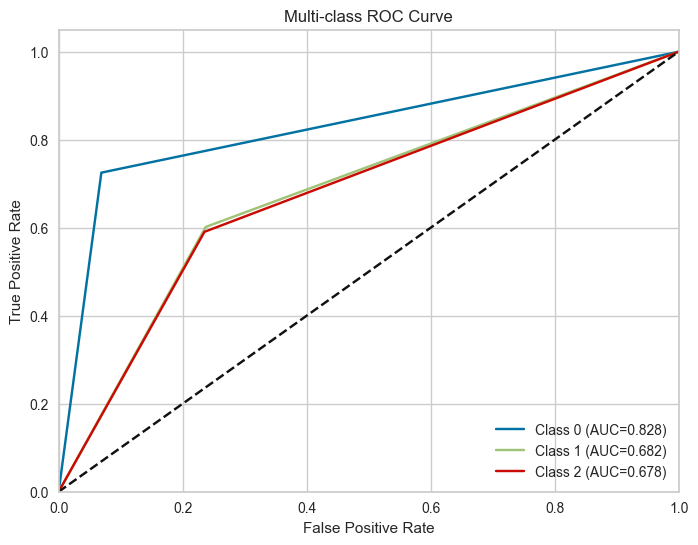

AUC scores for each class: {0: 0.8281442473674488, 1: 0.6822823464364245, 2: 0.6777423458474918}


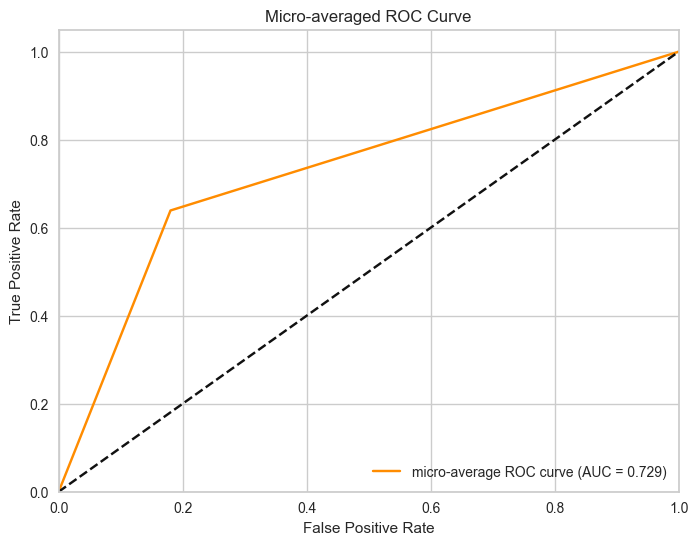

In [68]:
# Entraîner un modèle de régression logistique Ridge avec les meilleurs hyperparamètres
logregRidge = LogisticRegression(C=0.010606096740994778, penalty='l2', solver='saga', tol=10e-6, random_state=42)
logregRidge.fit(X_train_prep, y_train)

# Prédire les données test et évaluer le modèle
y_test_pred = logregRidge.predict(X_test_prep)
evaluate_model_multiclass(y_test, y_test_pred, logregRidge.classes_)

<font color='red'>**Commentaire**</font> 

En étudiant la matrice de confusion, nous remarquons que la plus grande faiblesse du modèle se trouve à deux niveaux : 
- prédire la classe 3 (fumeur) alors que l'étiquette est 2 (ancien fumeur)
- prédire la classe 2 (ancien fumeur) alors que l'étiquette est 3 (fumeur)

Rappelons que nous n'avons pas d'information supplémentaire sur les anciens fumeurs. Ils pourraient avoir arrêté de fumer il y a des dizaines d'années comme très récemment avant l'étude. Ainsi, il est plus ou moins compliqué de cerner la différence avec un fumeur. Nous pensons que cela n'est pas une faiblesse du modèle, mais simplement des valeurs features très difficiles à discriminer.

Nous allons fusionner ces deux classes et observer les résultats du modèle de régression logistique en conséquence.

## Fusion des classes 3 (fumeur) et 2 (ancien fumeur)

In [69]:
df = pd.read_csv(data_path)

# Fusionner les labels 2 et 3 en un seul label 2
df['SMK_stat_type_cd'] = df['SMK_stat_type_cd'].replace({3: 2})

# Sauvegarder le nouveau dataset
df.to_csv('../data/smoking_driking_dataset_Ver01_modified.csv', index=False)

In [70]:
df['SMK_stat_type_cd'].value_counts()

SMK_stat_type_cd
1.0    602441
2.0    388905
Name: count, dtype: int64

In [71]:
# Équilibrer le dataset
df_balanced = data_loader.balance_dataset('../data/smoking_driking_dataset_Ver01_modified.csv', 'SMK_stat_type_cd', '../data/balanced_smoking_drinking_dataset_modified.csv')

Distribution des classes dans le dataset équilibré :
SMK_stat_type_cd
1.0    388905
2.0    388905
Name: count, dtype: int64


In [73]:
def reduce_dataset(data_path, target_column, output_path, train_size=100000, random_state=42):
    """
    Réduit le dataset à un nombre spécifié de lignes tout en conservant les proportions des classes.
    
    Parameters:
    - data_path (str): Le chemin du fichier CSV à charger.
    - target_column (str): Le nom de la colonne cible pour le stratified sampling.
    - output_path (str): Le chemin du fichier CSV où sauvegarder le dataset réduit.
    - train_size (int): Le nombre de lignes du dataset réduit (par défaut 100 000).
    - random_state (int): La graine aléatoire pour la reproductibilité (par défaut 42).
    """
    # Charger les données
    df = pd.read_csv(data_path)
    
    # Réduire le dataset à la taille spécifiée en utilisant un échantillonnage stratifié
    df_reduced, _ = train_test_split(df, stratify=df[target_column], train_size=train_size, random_state=random_state)
    
    # Sauvegarder le nouveau dataset
    df_reduced.to_csv(output_path, index=False)
    
    # Vérifier la distribution des classes dans le nouvel ensemble de données
    distribution = df_reduced[target_column].value_counts()
    print("Distribution des classes dans le dataset réduit :")
    print(distribution)
    
    return df_reduced

In [75]:
df_reduced = reduce_dataset('../data/balanced_smoking_drinking_dataset_modified.csv', 'SMK_stat_type_cd', '../data/reduced_smoking_drinking_dataset.csv', train_size=100000)

Distribution des classes dans le dataset réduit :
SMK_stat_type_cd
1.0    50000
2.0    50000
Name: count, dtype: int64


In [76]:
cleaning.convertType(df_reduced, intToFloat, floatToInt)

cont_features = df_reduced.select_dtypes(include=['float64']).columns
cat_features = df_reduced.select_dtypes(include=['object', 'int64']).columns
cat_features = cat_features.drop(['SMK_stat_type_cd', 'DRK_YN'])

cont_features, cat_features

X = df_reduced.drop(columns=['SMK_stat_type_cd', 'DRK_YN'])
y = df_reduced['SMK_stat_type_cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train.value_counts(), y_test.value_counts()

X_train_prep, X_test_prep, selected_feature_names = preprocess_data(X_train, X_test, cont_features, cat_features, y_train, k)

Selected feature names: ['pipeline-1__height', 'pipeline-1__weight', 'pipeline-1__waistline', 'pipeline-1__SBP', 'pipeline-1__DBP', 'pipeline-1__HDL_chole', 'pipeline-1__triglyceride', 'pipeline-1__hemoglobin', 'pipeline-1__serum_creatinine', 'pipeline-1__SGOT_ALT', 'pipeline-1__gamma_GTP', 'pipeline-2__sex']


In [79]:
def evaluate_model_binary(y_true, y_pred, class_labels):
  """
  Evaluate a multi-class classification model using confusion matrix, classification metrics, 
  and ROC AUC.

  Args:
    y_true (array): True class labels.
    y_pred (array): Predicted class labels.
    class_labels (array): List of class labels.
  """
  # Plot confusion matrix
  plot_confusion_matrix(y_true, y_pred, classes=class_labels)

  # Calculate classification metrics
  # precision = precision_score(y_true, y_pred, average='weighted')
  # recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  # Display classification metrics
  print("*** Classification Metrics ***")
  # print("Precision =", precision)
  # print("Recall =", recall)
  print("F1 Score =", f1)
  print("******************************")

  # Binarize the output
  y_onehot_test = label_binarize(y_true, classes=class_labels)
  y_score = label_binarize(y_pred, classes=class_labels)

  # ROC AUC

  fpr, tpr, _ = roc_curve(y_onehot_test[:, 0], y_score[:, 0])
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (AUC=%0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

  # Print AUC score
  print("AUC score:", roc_auc)


*** Test Set ***


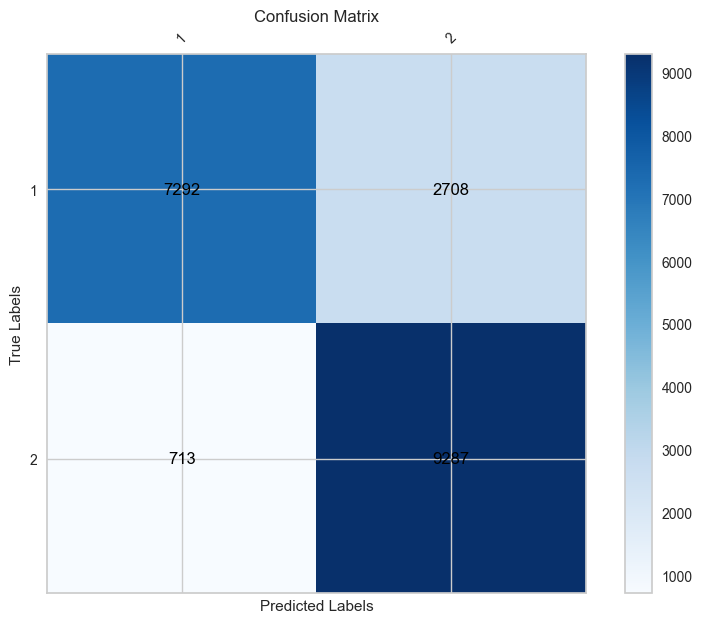

*** Classification Metrics ***
F1 Score = 0.8272309370253356
******************************


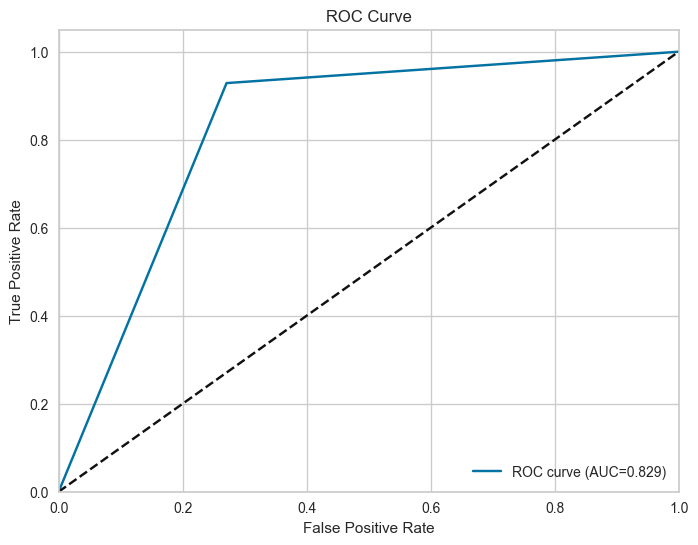

AUC score: 0.8289500000000001


In [80]:
logreg.fit(X_train_prep, y_train)

y_train_pred = logreg.predict(X_train_prep)
y_test_pred = logreg.predict(X_test_prep)
print("*** Test Set ***")
evaluate_model_binary(y_test, y_test_pred, logreg.classes_)

In [48]:
# Find the best model using Optuna
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2024-06-12 10:51:24,297] A new study created in memory with name: no-name-c7863ca5-68d7-40d4-93cf-c9f91dd2b715
C:\Users\33667\AppData\Local\Temp\ipykernel_1460\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.0001, 0.1)
[I 2024-06-12 10:51:29,606] Trial 0 finished with value: 0.825797896351141 and parameters: {'C': 0.0003775860476507921, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.825797896351141.
C:\Users\33667\AppData\Local\Temp\ipykernel_1460\4054425019.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.0001, 0.1)
[I 2024-06-12 10:51:37,498] Trial 1 finishe

Number of finished trials:  100
Best trial: {'C': 0.0010463186742213418, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\33667\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


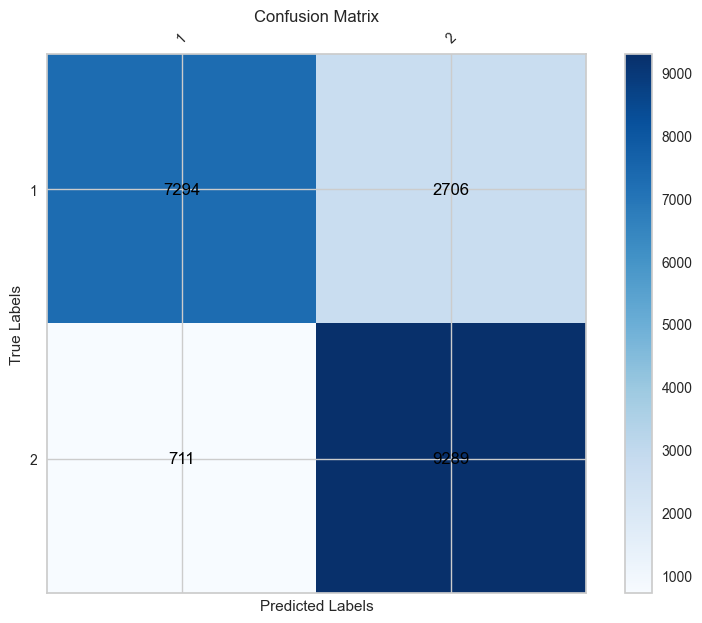

*** Classification Metrics ***
F1 Score = 0.8274329470375831
******************************


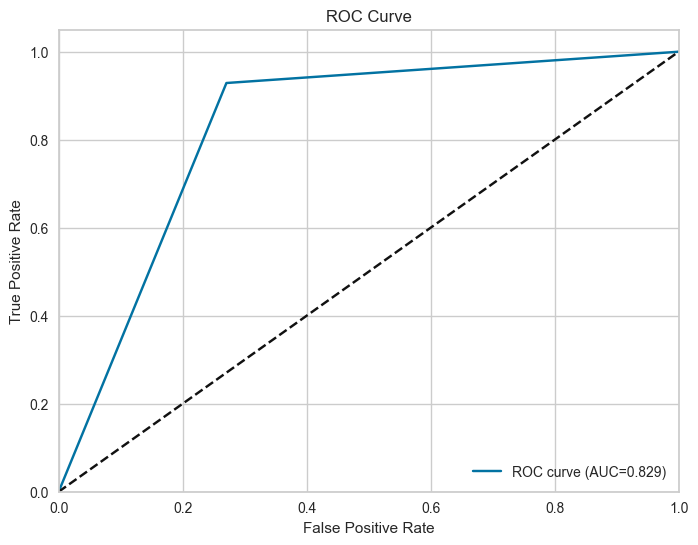

AUC score: 0.82915


In [82]:
# Train a logistic regression model with the best hyperparameters
logreg = LogisticRegression(C=0.0010463186742213418, penalty='l1', solver='saga', tol=10e-6, random_state=42)
logreg.fit(X_train_prep, y_train)

# Predict the test data and evaluate the model
y_test_pred = logreg.predict(X_test_prep)
evaluate_model_binary(y_test, y_test_pred, logreg.classes_)

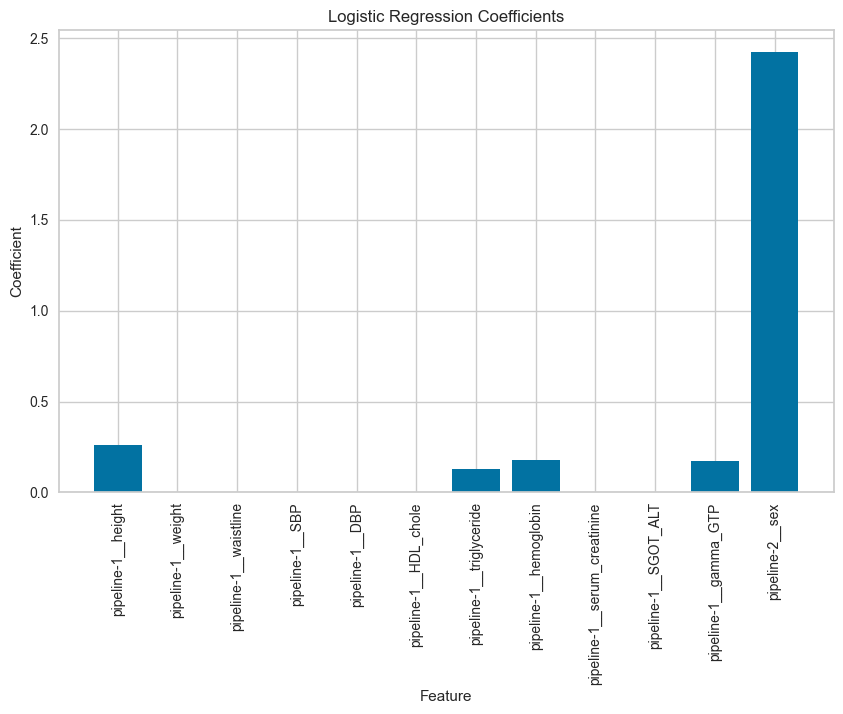

In [83]:
# Tracer les coefficients du modèle de régression logistique
def plot_coefficients(model, feature_names):
    """
    Plot the coefficients for a logistic regression model.

    Args:
        model: Trained logistic regression model.
        feature_names: List of feature names.
    """
    coef = model.coef_.ravel()
    
    # Plot the coefficients
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(coef)), coef)
    plt.xticks(np.arange(len(coef)), feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient')
    plt.title('Logistic Regression Coefficients')
    plt.grid(True)
    plt.show()

# Plot the coefficients
plot_coefficients(logreg, selected_feature_names)

<font color='red'>**Commentaire:**</font> 

Nous remarquons qu'une très grande importance est donnée au sexe dans la modélisation. Nous l'avions remarqué lors de l'AED : très peu de femmes sont fumeuses/ex-fumeuses. 

Nous avions également cité une possible différence de distribution pour les variables height, weight, hemoglobin, gamma_GTP et SGOT_ALT. Cela se reflète dans le coefficients du modèle pour les variables hemoglobin, weight et gamma_GTP.

<font color='red'>**Conclusion**</font> 

Nous concluons que la faiblesse du modèle de régression logistique multiclasse initial était bien dû à une frontière trop fine entre les valeurs des features pour les fumeurs et les anciens fumeurs. 

En regroupant ces deux classes et après optimisation, le modèle a une performance de 0,8274 (score F1). Les valeurs des coefficients sont également cohérentes avec les hypothèses formulées lors de l'AED.